In [1]:
import os
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from utils.kaggle_data_loader import KaggleDataLoader
from utils.kaggle_dataset import KaggleDataSet

e:\life\edu\NU-DAE\IE 7500 - NLP\proj\venv-nlp-project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
kaggle_path = "kritanjalijain/amazon-reviews"

kaggle_data_loader = KaggleDataLoader(kaggle_path)
path = kaggle_data_loader.load_data(KaggleDataSet.get_kaggle_column_names())

print("Path to dataset files:", path)
print(path)
print(os.listdir(path))

kaggle_dataset = KaggleDataSet(kaggle_data_loader)
train_df = kaggle_dataset.get_train_df()
test_df = kaggle_dataset.get_test_df()

print(train_df.head())

train_texts = train_df[KaggleDataSet.get_review_column_name()].tolist()
test_texts = test_df[KaggleDataSet.get_review_column_name()].tolist()

train_labels = (train_df[KaggleDataSet.get_kaggle_polarity_column_name()]).tolist() 
test_labels = (test_df[KaggleDataSet.get_kaggle_polarity_column_name()]).tolist()

print("Train shape:", train_df.shape)
print("Test shape: ", test_df.shape)

Path to dataset files: C:\Users\hOm3b\.cache\kagglehub\datasets\kritanjalijain\amazon-reviews\versions\2
C:\Users\hOm3b\.cache\kagglehub\datasets\kritanjalijain\amazon-reviews\versions\2
['amazon_review_polarity_csv.tgz', 'test.csv', 'train.csv']
Path to dataset files: C:\Users\hOm3b\.cache\kagglehub\datasets\kritanjalijain\amazon-reviews\versions\2
C:\Users\hOm3b\.cache\kagglehub\datasets\kritanjalijain\amazon-reviews\versions\2
['amazon_review_polarity_csv.tgz', 'test.csv', 'train.csv']
   Kaggle_Label                                              Title  \
0             2                     Stuning even for the non-gamer   
1             2              The best soundtrack ever to anything.   
2             2                                           Amazing!   
3             2                               Excellent Soundtrack   
4             2  Remember, Pull Your Jaw Off The Floor After He...   

                                              Review  
0  This sound track was beauti

In [3]:
print("Unique Kaggle label counts.  Unique values should be 1s and 2s")
print(train_df[KaggleDataSet.get_kaggle_polarity_column_name()].value_counts())
print(test_df[KaggleDataSet.get_kaggle_polarity_column_name()].value_counts())

Unique Kaggle label counts.  Unique values should be 1s and 2s
Kaggle_Label
2    1800000
1    1800000
Name: count, dtype: int64
Kaggle_Label
2    200000
1    200000
Name: count, dtype: int64


In [4]:
train_review_lengths = train_df[KaggleDataSet.get_review_column_name()].str.len()
print("Train dataset, Review column's length:\n")
reformatted_desc = train_review_lengths.describe().round(2)

# Convert from scientific notation to 2 decimal only
print(reformatted_desc.apply(lambda x: f"{x:.2f}"))

Train dataset, Review column's length:

count    3600000.00
mean         405.14
std          234.27
min            4.00
25%          207.00
50%          356.00
75%          566.00
max         1010.00
Name: Review, dtype: object


In [5]:
test_review_lengths = test_df[KaggleDataSet.get_review_column_name()].str.len()
print("Test dataset, Review column's length:\n")
reformatted_desc = test_review_lengths.describe().round(2)

# Convert from scientific notation to 2 decimal only
print(reformatted_desc.apply(lambda x: f"{x:.2f}"))

Test dataset, Review column's length:

count    400000.00
mean        404.90
std         234.11
min          15.00
25%         207.00
50%         356.00
75%         565.00
max        1009.00
Name: Review, dtype: object


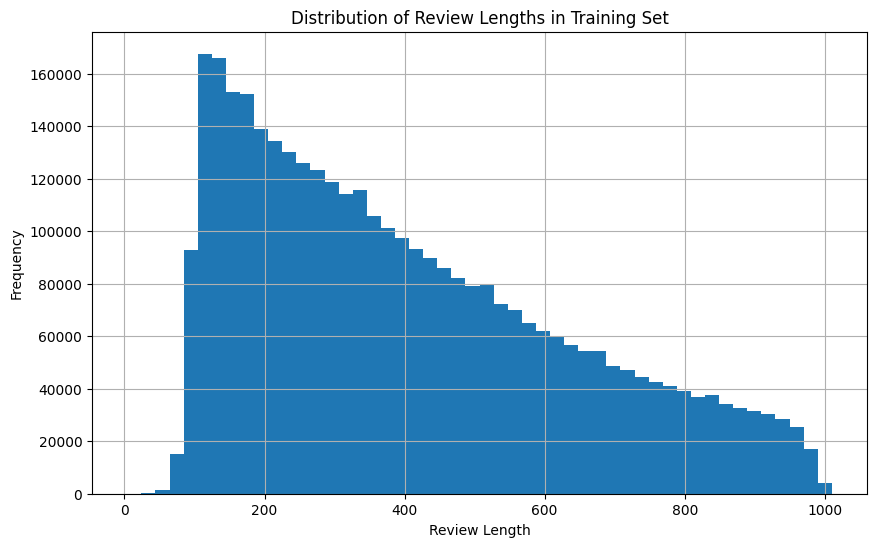

In [6]:
text_length_df = train_df[KaggleDataSet.get_review_column_name()].copy()
text_length_df['text_length_column'] = train_df[KaggleDataSet.get_review_column_name()].str.len()

# Visualize text length distribution
plt.figure(figsize=(10, 6))
text_length_df['text_length_column'].hist(bins=50)
plt.title('Distribution of Review Lengths in Training Set')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

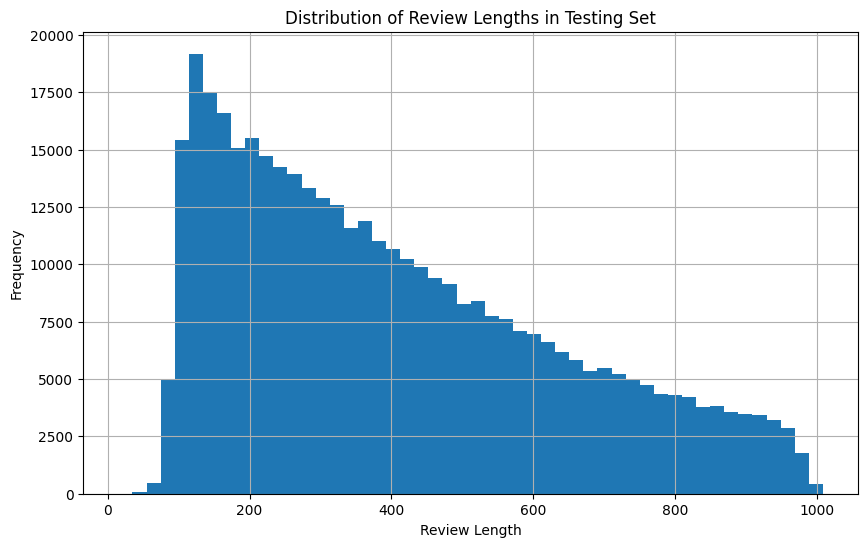

In [7]:
test_text_length_df = test_df[KaggleDataSet.get_review_column_name()].copy()
test_text_length_df['text_length_column'] = test_df[KaggleDataSet.get_review_column_name()].str.len()

# Visualize text length distribution
plt.figure(figsize=(10, 6))
test_text_length_df['text_length_column'].hist(bins=50)
plt.title('Distribution of Review Lengths in Testing Set')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
###
### This may take a bit of time to run
###

'''

from itertools import chain

def get_unique_words(series):
    # To lowercase and split into words, handling NaN
    words = (review.lower().split() for review in series if isinstance(review, str))
    # Flatten and convert to set
    return set(chain(*words))


# Apply to 'review' column
unique_words = get_unique_words(train_df[KaggleDataSet.REVIEW_COLUMN_NAME])
num_unique_words = len(unique_words)

print(f"Number of unique words in all the reviews: {num_unique_words}")
'''

In [8]:
### Generate word cloud for the title column

avg_title_length = int(round(train_df[KaggleDataSet.get_title_column_name()].str.len().mean()))
print(f"Average Title length {avg_title_length}")

title_wordcloud = WordCloud(background_color='black', max_words=avg_title_length).generate(str(train_df[KaggleDataSet.get_title_column_name()]))

Average Title length 25


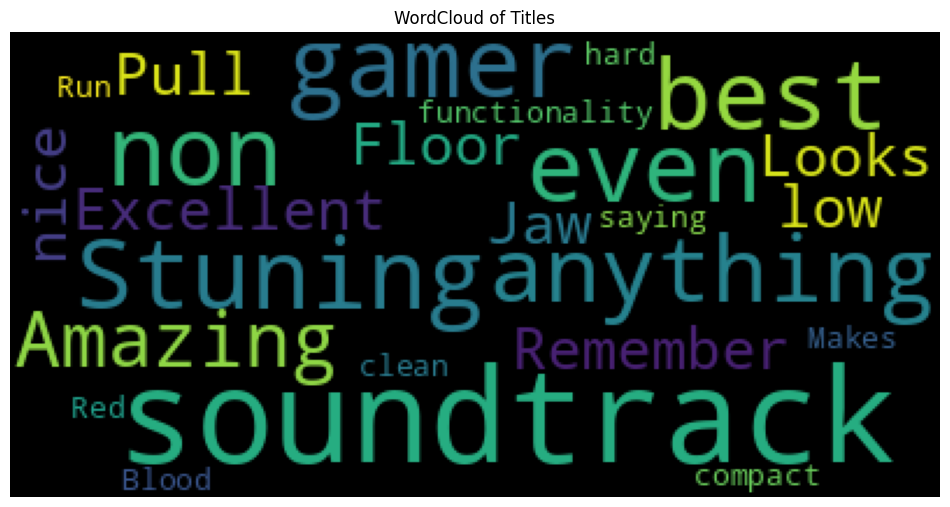

In [9]:
fig = plt.figure(figsize=[12,12])
plt.title('WordCloud of Titles')
plt.axis('off')
plt.imshow(title_wordcloud)
plt.show()

In [10]:
### Generate word cloud for the review column

avg_review_length = int(round(train_df[KaggleDataSet.get_review_column_name()].str.len().mean()))
print(f"Average Review length {avg_review_length}")

review_wordcloud = WordCloud(background_color='black', max_words=avg_review_length).generate(str(train_df[KaggleDataSet.get_review_column_name()]))

Average Review length 405


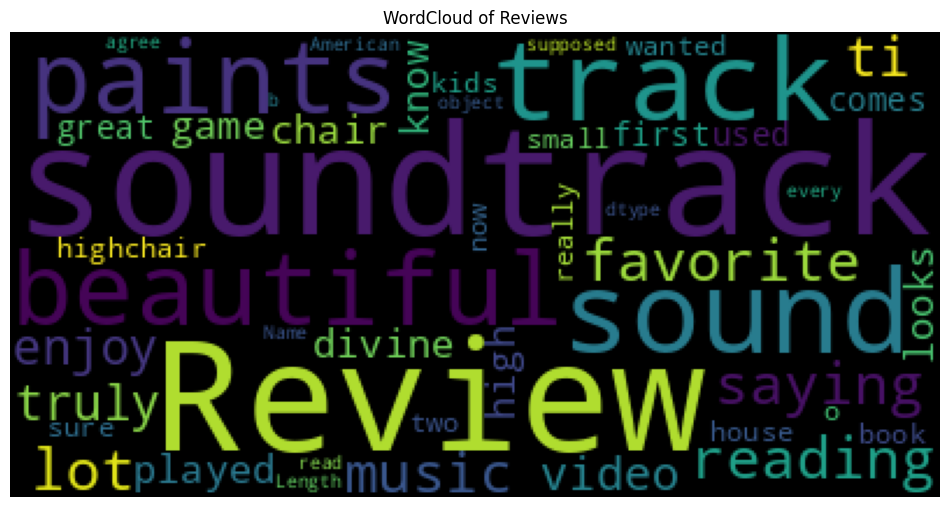

In [11]:
fig = plt.figure(figsize=[12,12])
plt.title('WordCloud of Reviews')
plt.axis('off')
plt.imshow(review_wordcloud)
plt.show()